In [2]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

In [9]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/eventB_pulse10_bdy' 
gridT = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_T.nc')
depth_levels = np.asfarray(gridT['deptht'])

In [47]:
depth_shelf_approx = 80
ind_shelf = np.argmin(np.abs(depth_levels - depth_shelf_approx))
depth_shelf = depth_levels[ind_shelf]

ind_plane = np.argmin(np.abs(bathy[:,0] - depth_shelf))

bathy_plane = bathy[ind_plane,:]

depth_canyon_approx = bathy_plane.max()
ind_canyon = np.argmin(np.abs(depth_levels - depth_canyon_approx))
depth_canyon = depth_levels[ind_canyon]

ind_axis = np.where(bathy_plane == depth_canyon_approx)[0][0]

slope = abs(np.diff(bathy_plane))
ind_rimL0 = np.where(slope > 0.01)[0][0]
ind_rimR0 = np.where(slope > 0.01)[0][-1]
width_shelf = max(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
ind_rimL = ind_axis - width_shelf
ind_rimR = ind_axis + width_shelf

ind_shfL = ind_rimL - width_shelf
ind_shfR = ind_rimR + width_shelf

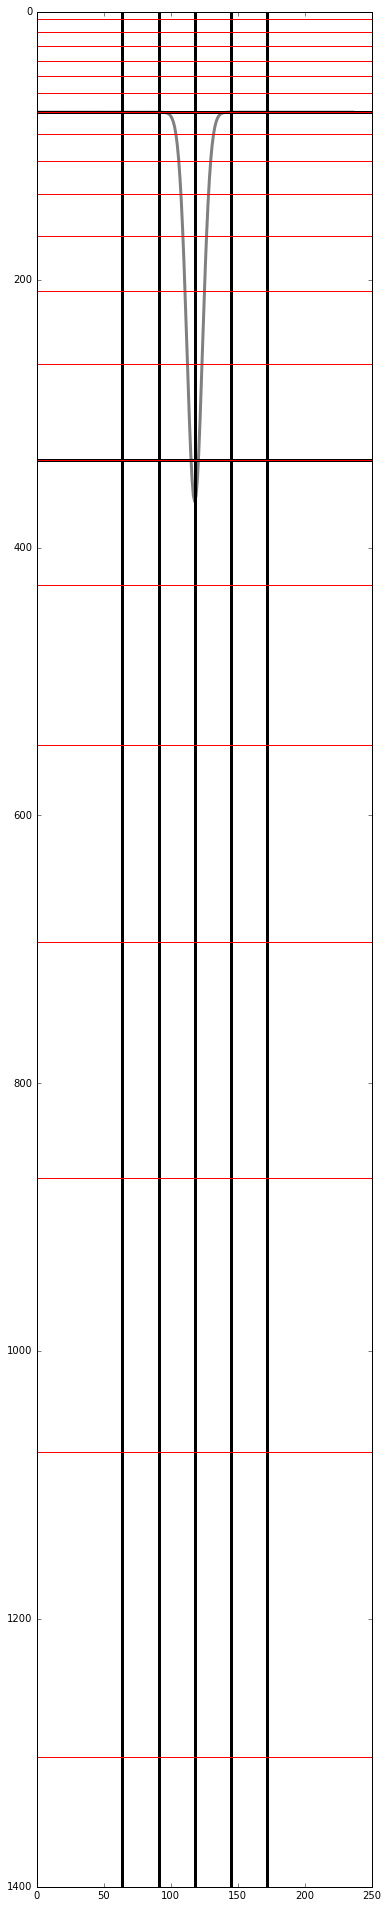

In [51]:
fig, ax = plt.subplots(1,1,figsize=(6,6*5.6))
ax.plot(bathy_plane, lw=3, c='gray')
ax.invert_yaxis()

lw, c =3, 'k'

ax.axhline(depth_shelf, c=c, lw=lw)
ax.axhline(depth_canyon, c=c, lw=lw)

ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)

for z in zip(depth_levels):
    ax.axhline(z, c='r')

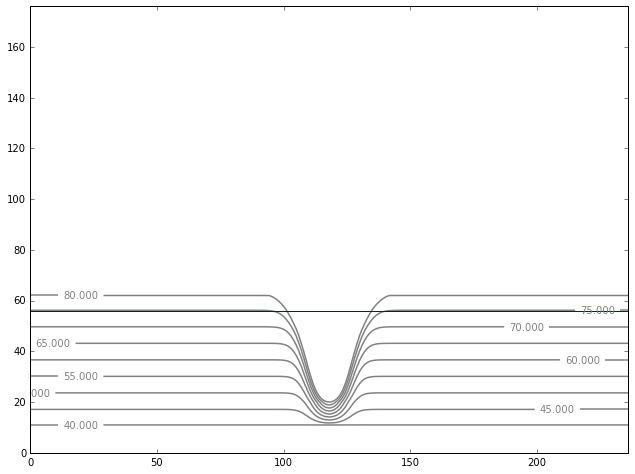

In [43]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*8, 8))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=1.5)
ax.clabel(c, inline=1, fontsize=10)

ax.axhline(ind_plane)